In [41]:
import pandas as pd
import numpy as np
import random
import json
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from bayes_opt import BayesianOptimization
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

SEED = 42

random.seed(SEED)
np.random.seed(SEED)

In [42]:
df_raw = pd.read_csv('../df_clean.csv', index_col=0)

df_raw.head()

,category,amt,gender,is_fraud,transaction_month,transaction_day,transaction_hour,transaction_day_of_week,transaction_is_weekend,age,time_category
0,misc_net,4.97,F,0,1,1,0,1,0,30,midnight
1,grocery_pos,107.23,F,0,1,1,0,1,0,40,midnight
2,entertainment,220.11,M,0,1,1,0,1,0,56,midnight
3,gas_transport,45.00,M,0,1,1,0,1,0,51,midnight
4,misc_pos,41.96,M,0,1,1,0,1,0,32,midnight


In [43]:
df_raw.drop(['gender'], axis=1, inplace=True)
df_raw

,category,amt,is_fraud,transaction_month,transaction_day,transaction_hour,transaction_day_of_week,transaction_is_weekend,age,time_category
0,misc_net,4.97,0,1,1,0,1,0,30,midnight
1,grocery_pos,107.23,0,1,1,0,1,0,40,midnight
2,entertainment,220.11,0,1,1,0,1,0,56,midnight
3,gas_transport,45.00,0,1,1,0,1,0,51,midnight
4,misc_pos,41.96,0,1,1,0,1,0,32,midnight
...,...,...,...,...,...,...,...,...,...,...
1296670,entertainment,15.56,0,6,21,12,6,1,58,afternoon
1296671,food_dining,51.70,0,6,21,12,6,1,40,afternoon
1296672,food_dining,105.93,0,6,21,12,6,1,52,afternoon
1296673,food_dining,74.90,0,6,21,12,6,1,39,afternoon


In [44]:
df = pd.get_dummies(df_raw, columns=['category'], prefix='cat')
df

,amt,is_fraud,transaction_month,transaction_day,transaction_hour,transaction_day_of_week,transaction_is_weekend,age,time_category,cat_entertainment,...,cat_grocery_pos,cat_health_fitness,cat_home,cat_kids_pets,cat_misc_net,cat_misc_pos,cat_personal_care,cat_shopping_net,cat_shopping_pos,cat_travel
0,4.97,0,1,1,0,1,0,30,midnight,False,...,False,False,False,False,True,False,False,False,False,False
1,107.23,0,1,1,0,1,0,40,midnight,False,...,True,False,False,False,False,False,False,False,False,False
2,220.11,0,1,1,0,1,0,56,midnight,True,...,False,False,False,False,False,False,False,False,False,False
3,45.00,0,1,1,0,1,0,51,midnight,False,...,False,False,False,False,False,False,False,False,False,False
4,41.96,0,1,1,0,1,0,32,midnight,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,15.56,0,6,21,12,6,1,58,afternoon,True,...,False,False,False,False,False,False,False,False,False,False
1296671,51.70,0,6,21,12,6,1,40,afternoon,False,...,False,False,False,False,False,False,False,False,False,False
1296672,105.93,0,6,21,12,6,1,52,afternoon,False,...,False,False,False,False,False,False,False,False,False,False
1296673,74.90,0,6,21,12,6,1,39,afternoon,False,...,False,False,False,False,False,False,False,False,False,False


Text(0, 0.5, 'Jumlah Transaksi Fraud')

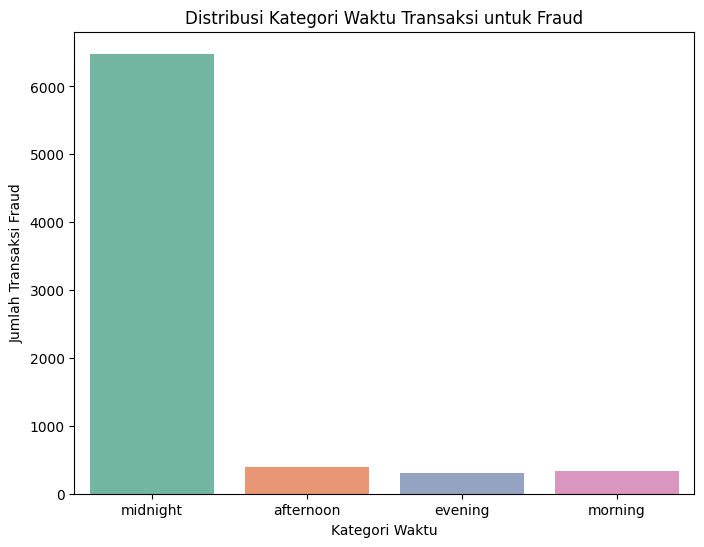

In [45]:
# Plotting kategori waktu untuk fraud
df_fraud = df[df.is_fraud == 1]
plt.figure(figsize=(8, 6))
sns.countplot(x='time_category', data=df_fraud, palette='Set2')
plt.title('Distribusi Kategori Waktu Transaksi untuk Fraud')
plt.xlabel('Kategori Waktu')
plt.ylabel('Jumlah Transaksi Fraud')

In [46]:
# Hitung distribusi persentase kategori
category_percentage = df[df.is_fraud == 1]['time_category'].value_counts(normalize=True)

# Buat dictionary untuk label encoding berdasarkan persentase distribusi
label_encoding = {category: percentage for category, percentage in category_percentage.items()}

# Terapkan label encoding ke kolom time_category
df['time_category_encoded'] = df['time_category'].map(label_encoding)

df.drop(['time_category'], axis=1, inplace=True)
df

,amt,is_fraud,transaction_month,transaction_day,transaction_hour,transaction_day_of_week,transaction_is_weekend,age,cat_entertainment,cat_food_dining,...,cat_health_fitness,cat_home,cat_kids_pets,cat_misc_net,cat_misc_pos,cat_personal_care,cat_shopping_net,cat_shopping_pos,cat_travel,time_category_encoded
0,4.97,0,1,1,0,1,0,30,False,False,...,False,False,False,True,False,False,False,False,False,0.863576
1,107.23,0,1,1,0,1,0,40,False,False,...,False,False,False,False,False,False,False,False,False,0.863576
2,220.11,0,1,1,0,1,0,56,True,False,...,False,False,False,False,False,False,False,False,False,0.863576
3,45.00,0,1,1,0,1,0,51,False,False,...,False,False,False,False,False,False,False,False,False,0.863576
4,41.96,0,1,1,0,1,0,32,False,False,...,False,False,False,False,True,False,False,False,False,0.863576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,15.56,0,6,21,12,6,1,58,True,False,...,False,False,False,False,False,False,False,False,False,0.051692
1296671,51.70,0,6,21,12,6,1,40,False,True,...,False,False,False,False,False,False,False,False,False,0.051692
1296672,105.93,0,6,21,12,6,1,52,False,True,...,False,False,False,False,False,False,False,False,False,0.051692
1296673,74.90,0,6,21,12,6,1,39,False,True,...,False,False,False,False,False,False,False,False,False,0.051692


In [47]:
# Pisahkan X (fitur) dan y (target)
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Split data menjadi training dan testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

In [48]:
scaler = StandardScaler()
numerical_features = ['amt','age']

In [49]:
# SMOTE Oversampling
smote = SMOTE(random_state=SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scaling setelah oversampling (fit pada data training)
X_train_smote[numerical_features] = scaler.fit_transform(X_train_smote[numerical_features])

In [50]:
# ADASYN Oversampling
adasyn = ADASYN(random_state=SEED)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Scaling setelah oversampling (fit pada data training)
X_train_adasyn[numerical_features] = scaler.fit_transform(X_train_adasyn[numerical_features])

In [51]:
# Scaling data test (transform tanpa fit ulang)
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# scaling untuk data train tanpa oversampling
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])

In [52]:
def build_train_model(method, model_name, params):
    model = None
    if model_name == 'adaboost':
        model = AdaBoostClassifier(n_estimators=int(params['n_estimators']), learning_rate=params['learning_rate'])
    elif model_name == 'random_forest':
        model = RandomForestClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']))
    elif model_name == 'decision_tree':
        model = DecisionTreeClassifier(max_depth=int(params['max_depth']), min_samples_split=int(params['min_samples_split']))
    elif model_name == 'logistic_regression':
        model = LogisticRegression(C=params['C'], solver='liblinear')
    else:
        raise ValueError("Unknown model")

    # chose training set
    X_resampled, y_resampled = None, None
    if method is None or method == 'no_oversampling':
        X_resampled, y_resampled = X_train, y_train
    elif method == 'smote':
        X_resampled, y_resampled = X_train_smote, y_train_smote
    elif method == 'adasyn':
        X_resampled, y_resampled = X_train_adasyn, y_train_adasyn
    else:
        raise ValueError("Unknown method")

    # perform training
    model.fit(X_resampled, y_resampled)
    return model
    

In [53]:
# Objective Function for Bayesian Optimization
def optimize_model(method, model_name, params):
    model = build_train_model(method, model_name, params)

    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Return accuracy as score
    score = accuracy_score(y_test, y_pred)
    
    return score

In [54]:
def run_bayesian_optimization(model_name, method, pbounds):
    optimizer = BayesianOptimization(
        f=lambda **params: optimize_model(method, model_name, params),
        pbounds=pbounds,
        random_state=SEED,
        verbose=2
    )
    optimizer.maximize(init_points=5, n_iter=5)
    return optimizer

In [55]:
def save_best_params_to_json(best_params, filename="best_params.json"):
    with open(filename, 'w') as json_file:
        json.dump(best_params, json_file, indent=4)
    print(f"Best parameters saved to {filename}")

In [56]:
def save_model_to_file(model, filename="model.pkl"):
    with open(filename,'wb') as f:
        pickle.dump(model,f)

In [57]:
# Parameter Bounds for model
params_adaboost = {
    'n_estimators': (50, 500),
    'learning_rate': (0.01, 1)
}

params_random_forest = {
    'n_estimators': (50, 500),
    'max_depth': (5, 30)
}

params_decision_tree = {
    'max_depth': (5, 30),
    'min_samples_split': (2, 10)
}

params_logistic_regression = {
    'C': (0.01, 10)
}

MODEL_DICT = {
    'adaboost': {
        'pbounds': params_adaboost,
    },
    'random_forest': {
        'pbounds': params_random_forest,
    },
    'decision_tree': {
        'pbounds': params_decision_tree,
    },
    'logistic_regression': {
        'pbounds': params_logistic_regression,
    },
}

model_list = ['decision_tree','logistic_regression','adaboost','random_forest']
method_list = ['no_oversampling','smote','adasyn']

In [58]:
# hyperparameter tuning for each model and oversampling method

for model_name in model_list:
    MODEL_DICT[model_name]['params'] = {}
    pbounds = MODEL_DICT[model_name]['pbounds']
    for method in method_list:
        print(f"Finding best parameters for {model_name} with {method}")
        optimizer = run_bayesian_optimization(model_name, method=method, pbounds=pbounds)
        best_params = optimizer.max['params']
        print(f"Best parameters for {model_name} with {method}: ", best_params)
        save_best_params_to_json(best_params, filename=f"best_params_{model_name}_{method}.json")
        MODEL_DICT[model_name]['params'][method] = best_params

Finding best parameters for decision_tree with no_oversampling
|   iter    |  target   | max_depth | min_sa... |
-------------------------------------------------
| 1         | 0.8888    | 14.36     | 9.606     |
| 2         | 0.8853    | 23.3      | 6.789     |
| 3         | 0.8984    | 8.9       | 3.248     |
| 4         | 0.8941    | 6.452     | 8.929     |
| 5         | 0.8853    | 20.03     | 7.665     |
| 6         | 0.9941    | 5.0       | 2.0       |
| 7         | 0.9941    | 5.0       | 3.108     |
| 8         | 0.8828    | 30.0      | 2.0       |
| 9         | 0.8873    | 30.0      | 10.0      |
| 10        | 0.8836    | 17.75     | 2.0       |
Best parameters for decision_tree with no_oversampling:  {'max_depth': 5.0, 'min_samples_split': 2.0}
Best parameters saved to best_params_decision_tree_no_oversampling.json
Finding best parameters for decision_tree with smote
|   iter    |  target   | max_depth | min_sa... |
-------------------------------------------------
| 1       

In [59]:
# build and train each model and oversampling method

for model_name in MODEL_DICT:
    params = MODEL_DICT[model_name]['params']
    MODEL_DICT[model_name]['models'] = {}
    for method in params:
        print(f"Building and training model {model_name} with {method}")
        best_parameters = params[method]
        model = build_train_model(method, model_name, best_parameters)
        save_model_to_file(model, f"{model_name}_{method}.pkl")
        MODEL_DICT[model_name]['models'][method] = model

Building and training model adaboost with no_oversampling
Building and training model adaboost with smote
Building and training model adaboost with adasyn
Building and training model random_forest with no_oversampling
Building and training model random_forest with smote
Building and training model random_forest with adasyn
Building and training model decision_tree with no_oversampling
Building and training model decision_tree with smote
Building and training model decision_tree with adasyn
Building and training model logistic_regression with no_oversampling
Building and training model logistic_regression with smote
Building and training model logistic_regression with adasyn


In [60]:
# make predictions

for model_name in MODEL_DICT:
    methods = MODEL_DICT[model_name]['models']
    MODEL_DICT[model_name]['predictions'] = {}
    for method in methods:
        print(f"Making predictions model {model_name} with {method}")
        model = methods[method]
        y_pred = model.predict(X_test)
        MODEL_DICT[model_name]['predictions'][method] = y_pred

Making predictions model adaboost with no_oversampling
Making predictions model adaboost with smote
Making predictions model adaboost with adasyn
Making predictions model random_forest with no_oversampling
Making predictions model random_forest with smote
Making predictions model random_forest with adasyn
Making predictions model decision_tree with no_oversampling
Making predictions model decision_tree with smote
Making predictions model decision_tree with adasyn
Making predictions model logistic_regression with no_oversampling
Making predictions model logistic_regression with smote
Making predictions model logistic_regression with adasyn


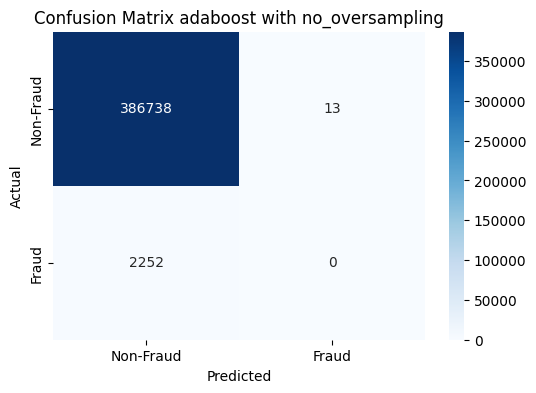

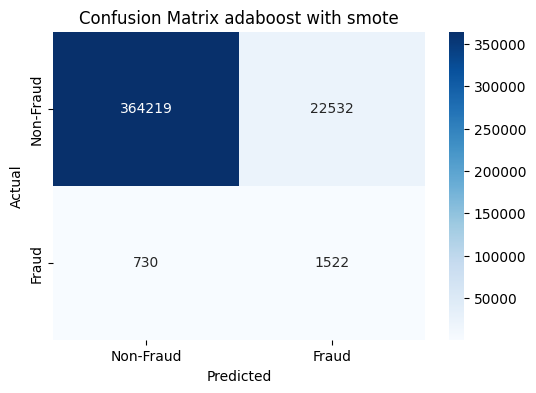

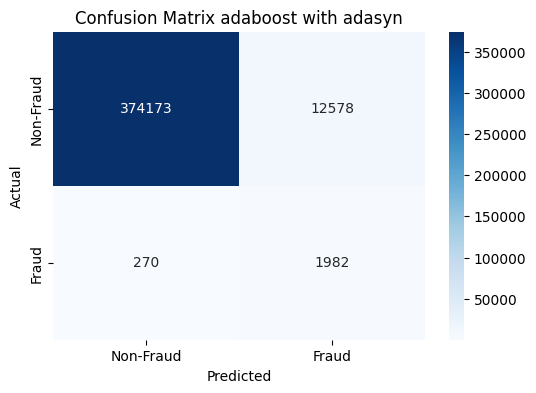

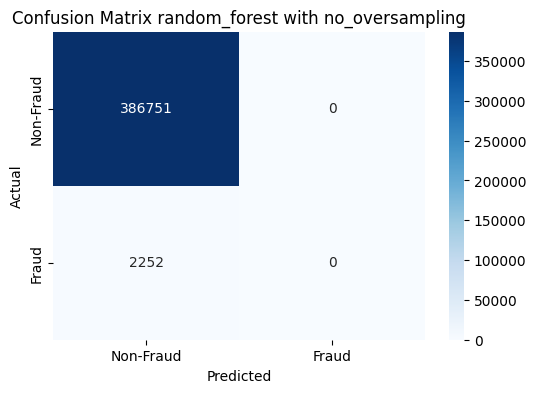

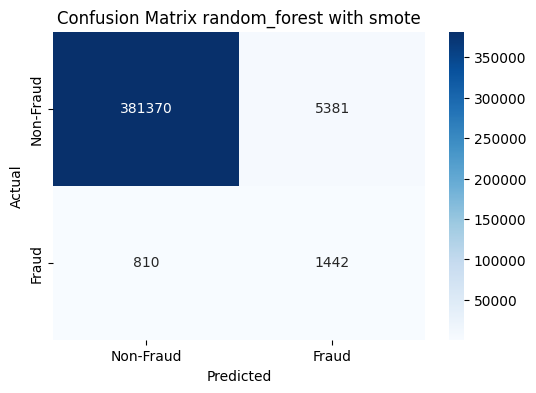

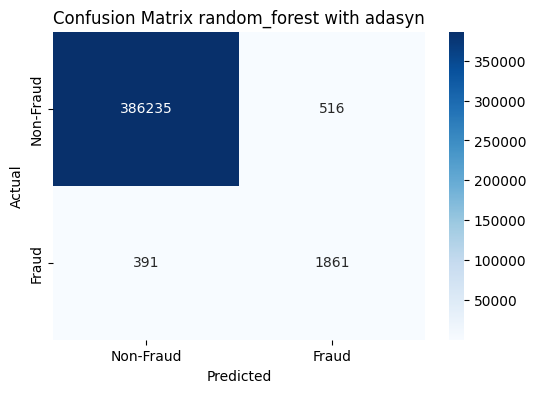

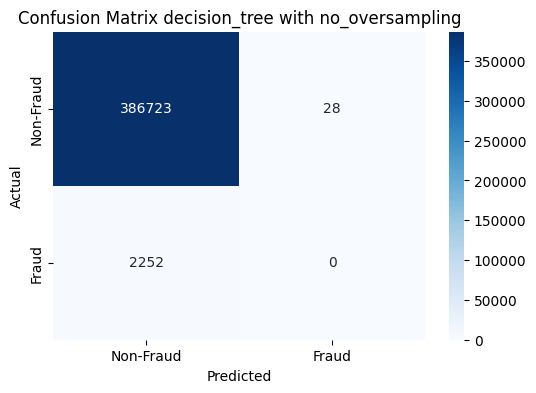

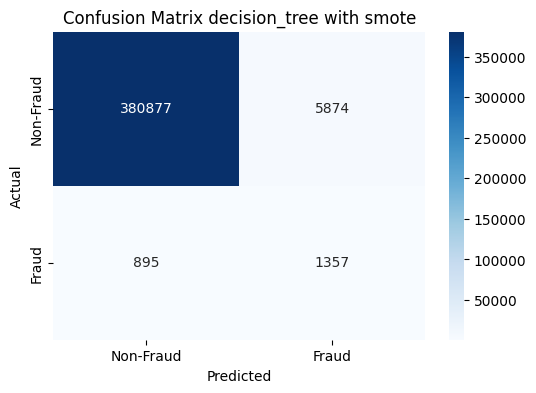

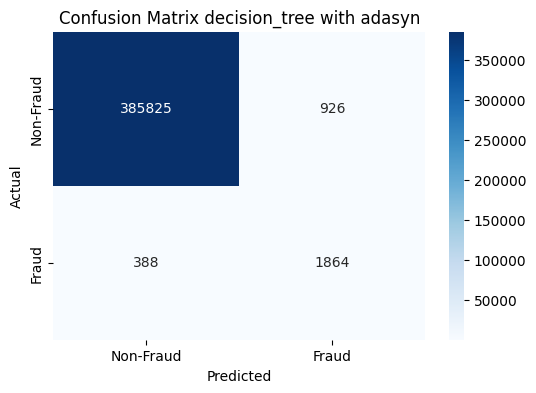

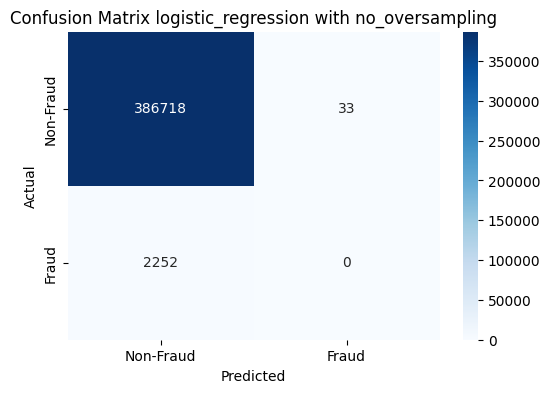

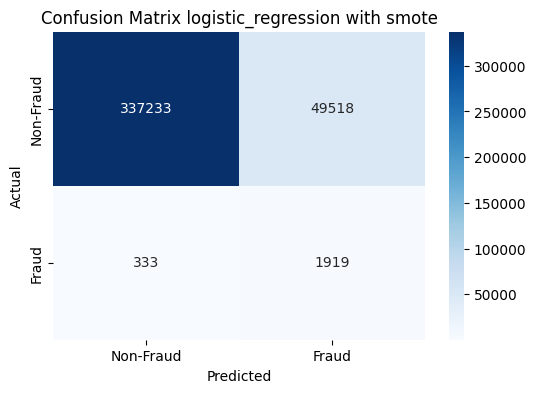

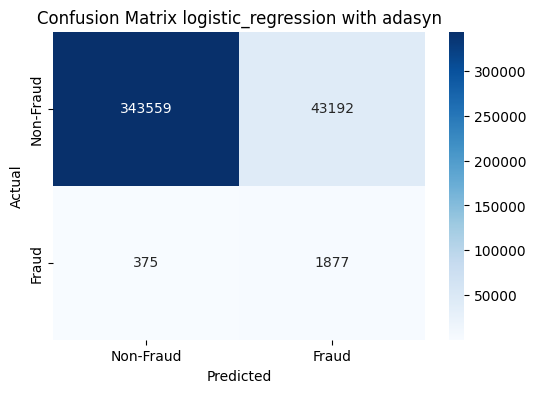

In [61]:
# show confusion matrix
for model_name in MODEL_DICT:
    methods = MODEL_DICT[model_name]['predictions']
    MODEL_DICT[model_name]['confusion_matrix'] = {}
    for method in methods:
        y_pred = methods[method]
        cm = confusion_matrix(y_test, y_pred)
        MODEL_DICT[model_name]['confusion_matrix'][method] = cm

        # Visualisasi Confusion Matrix
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f"Confusion Matrix {model_name} with {method}")
        plt.savefig(f"confusion_matrix_{model_name}_{method}")
        plt.show()


In [63]:
def save_report_to_json(cl_report, filename="cl_report.json"):
    with open(filename, 'w') as json_file:
        json.dump(cl_report, json_file, indent=4)
    print(f"Classification Report saved to {filename}")

Classification Report saved to cl_report_adaboost_no_oversampling.json


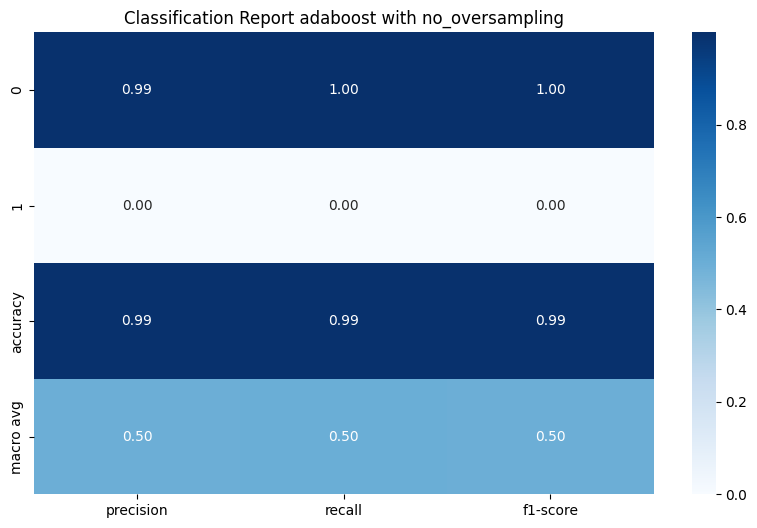

Classification Report saved to cl_report_adaboost_smote.json


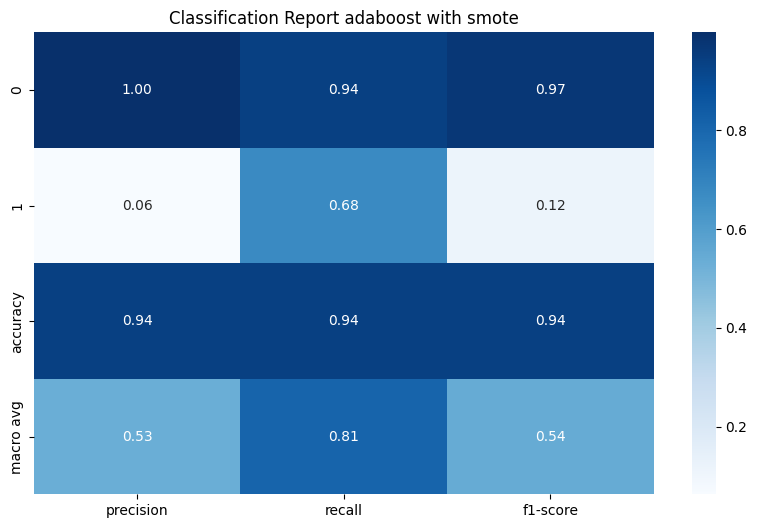

Classification Report saved to cl_report_adaboost_adasyn.json


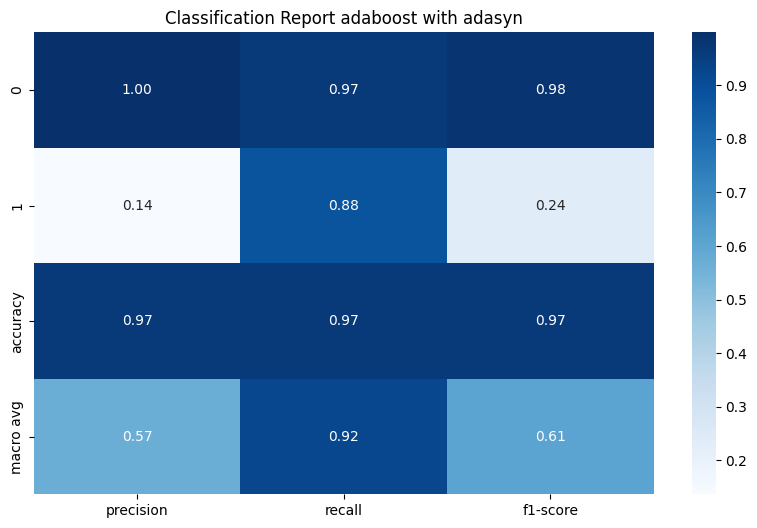

Classification Report saved to cl_report_random_forest_no_oversampling.json


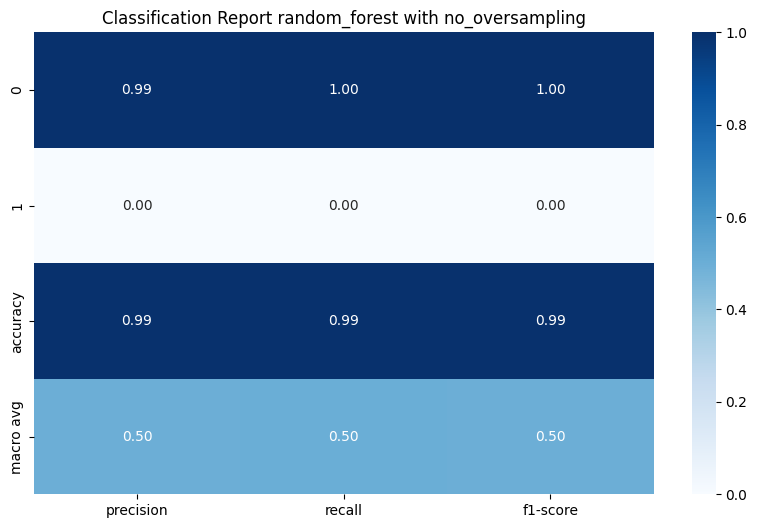

Classification Report saved to cl_report_random_forest_smote.json


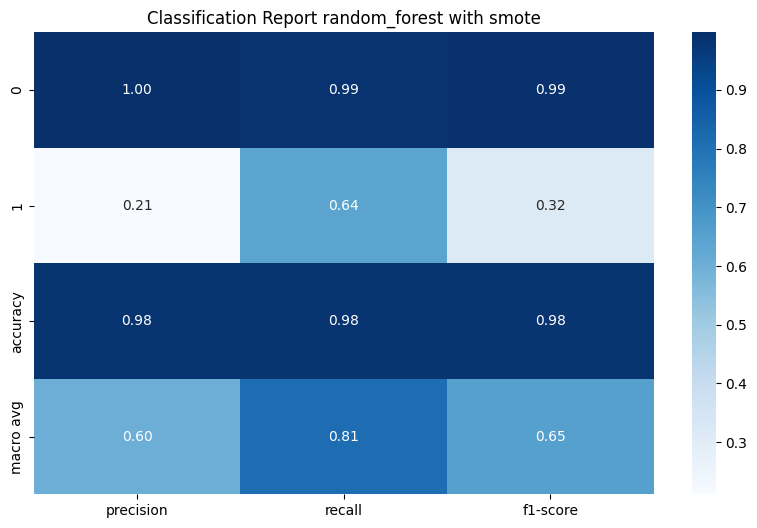

Classification Report saved to cl_report_random_forest_adasyn.json


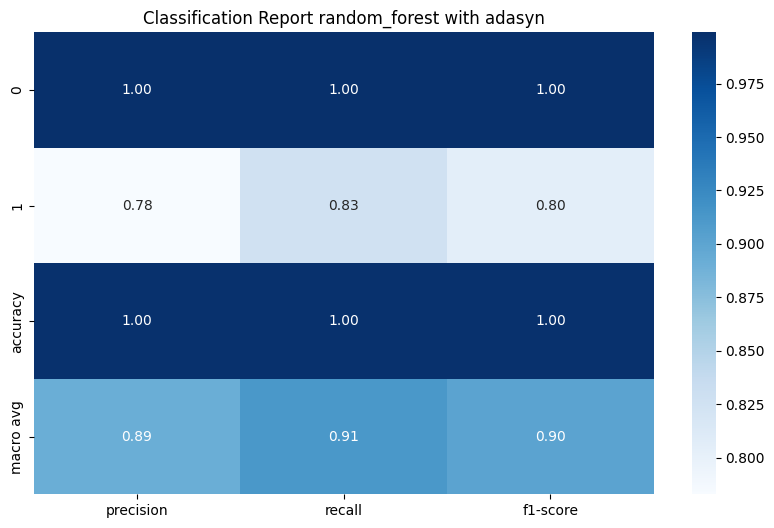

Classification Report saved to cl_report_decision_tree_no_oversampling.json


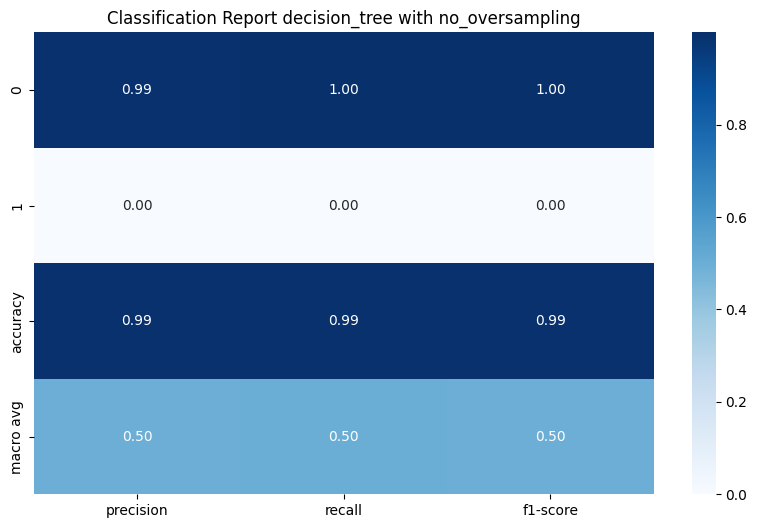

Classification Report saved to cl_report_decision_tree_smote.json


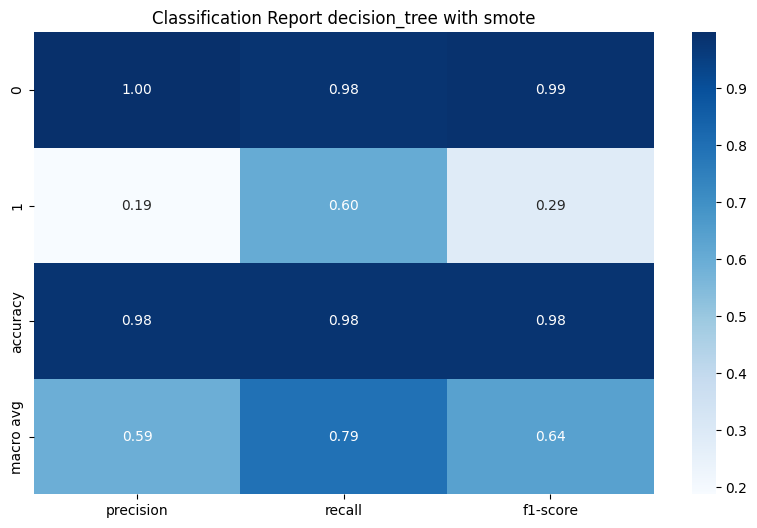

Classification Report saved to cl_report_decision_tree_adasyn.json


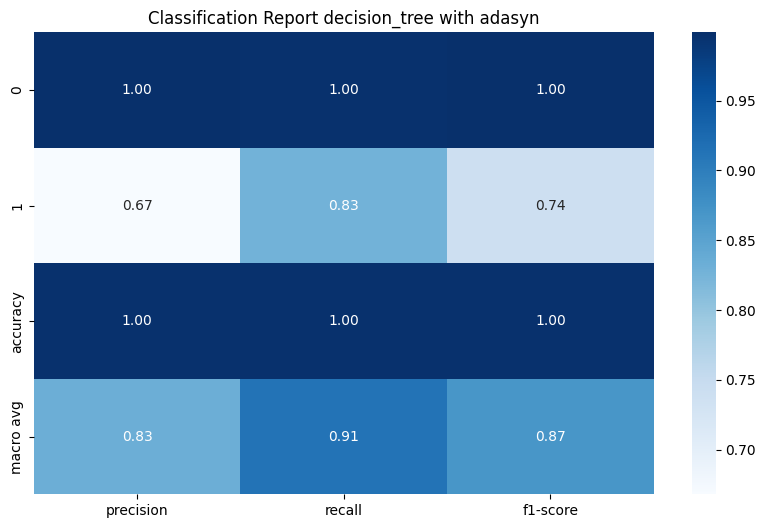

Classification Report saved to cl_report_logistic_regression_no_oversampling.json


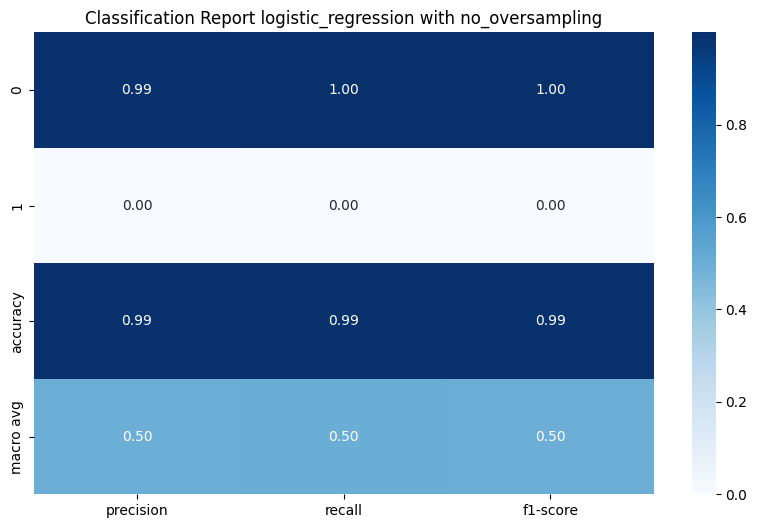

Classification Report saved to cl_report_logistic_regression_smote.json


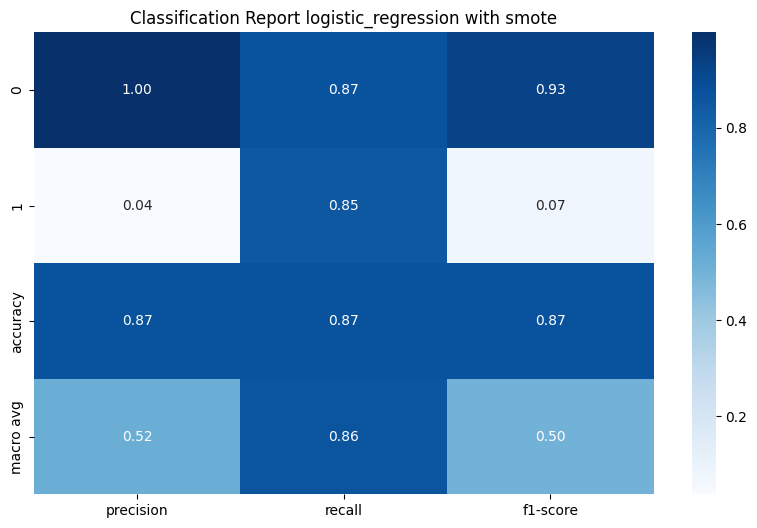

Classification Report saved to cl_report_logistic_regression_adasyn.json


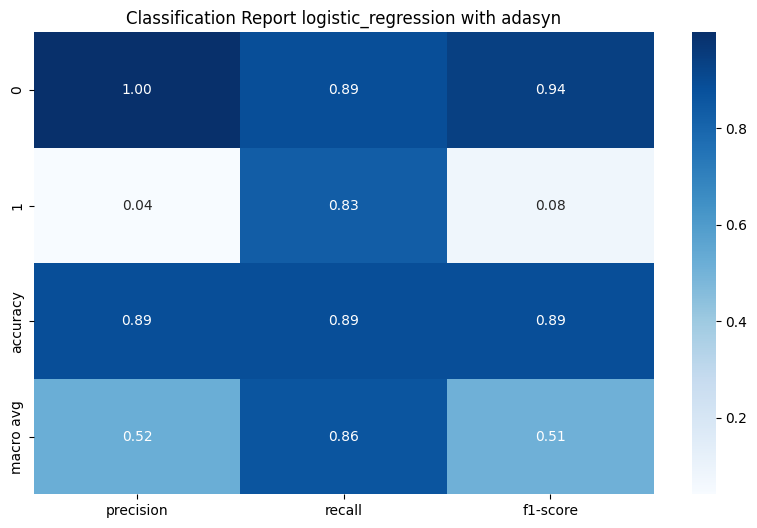

In [64]:
# show classification report
for model_name in MODEL_DICT:
    methods = MODEL_DICT[model_name]['predictions']
    MODEL_DICT[model_name]['classification_reports'] = {}
    for method in methods:
        y_pred = methods[method]
        cl_report = classification_report(y_test, y_pred, output_dict=True)
        save_report_to_json(cl_report, f"cl_report_{model_name}_{method}.json")
        cl_report_df = pd.DataFrame(cl_report).transpose()
        MODEL_DICT[model_name]['classification_reports'][method] = cl_report

        # Visualisasi laporan klasifikasi
        plt.figure(figsize=(10,6))
        sns.heatmap(cl_report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
        plt.title(f"Classification Report {model_name} with {method}")
        plt.savefig(f"classification_report_{model_name}_{method}")
        plt.show()


In [65]:
# show accuracy scores
for model_name in MODEL_DICT:
    methods = MODEL_DICT[model_name]['predictions']
    MODEL_DICT[model_name]['accuracy_scores'] = {}
    for method in methods:
        y_pred = methods[method]
        acc_score = accuracy_score(y_test, y_pred)
        MODEL_DICT[model_name]['accuracy_scores'][method] = acc_score
        print(f"Accuracy {model_name} with {method}: ", acc_score)


Accuracy adaboost with no_oversampling:  0.9941774227962252
Accuracy adaboost with smote:  0.9402009753138151
Accuracy adaboost with adasyn:  0.9669719770798683
Accuracy random_forest with no_oversampling:  0.9942108415616332
Accuracy random_forest with smote:  0.9840849556430156
Accuracy random_forest with adasyn:  0.9976683984442279
Accuracy decision_tree with no_oversampling:  0.9941388626822929
Accuracy decision_tree with smote:  0.9825991059194916
Accuracy decision_tree with adasyn:  0.996622134019532
Accuracy logistic_regression with no_oversampling:  0.9941260093109822
Accuracy logistic_regression with smote:  0.8718493173574496
Accuracy logistic_regression with adasyn:  0.8880034344208142


In [66]:
# Create a dictionary with the data
data_scores = {
    'Model': [],
    'Oversampling Method': [],
    'Accuracy Score': []
}

for model_name in MODEL_DICT:
    methods = MODEL_DICT[model_name]['accuracy_scores']
    for method in methods:
        acc_scores = methods[method]
        data_scores['Model'].append(model_name)
        data_scores['Oversampling Method'].append(method)
        data_scores['Accuracy Score'].append(acc_scores)

# Convert the dictionary to a DataFrame
accuracy_df = pd.DataFrame(data_scores)
accuracy_df

,Model,Oversampling Method,Accuracy Score
0,adaboost,no_oversampling,0.994177
1,adaboost,smote,0.940201
2,adaboost,adasyn,0.966972
3,random_forest,no_oversampling,0.994211
4,random_forest,smote,0.984085
5,random_forest,adasyn,0.997668
6,decision_tree,no_oversampling,0.994139
7,decision_tree,smote,0.982599
8,decision_tree,adasyn,0.996622
9,logistic_regression,no_oversampling,0.994126


In [67]:
accuracy_df.to_csv('accuracy_scores.csv', index=False)

In [68]:
data_cl_report = {}

for model_name in MODEL_DICT:
    methods = MODEL_DICT[model_name]['classification_reports']
    for method in methods:
        cl_report = methods[method]
        data_cl_report[f"{model_name}_{method}"] = cl_report

# Mengubah hasil evaluasi menjadi pandas DataFrame
data_cl_report_df = pd.DataFrame.from_dict({
    (model, metric): values 
    for model, metrics in data_cl_report.items() 
    for metric, values in metrics.items() if metric != 'accuracy'
}, orient='index')

data_cl_report_df

precision    recall  \
adaboost_no_oversampling            0              0.994211  0.999966   
                                    1              0.000000  0.000000   
                                    macro avg      0.497105  0.499983   
                                    weighted avg   0.988455  0.994177   
adaboost_smote                      0              0.998000  0.941740   
                                    1              0.063274  0.675844   
                                    macro avg      0.530637  0.808792   
                                    weighted avg   0.992588  0.940201   
adaboost_adasyn                     0              0.999279  0.967478   
                                    1              0.136126  0.880107   
                                    macro avg      0.567703  0.923792   
                                    weighted avg   0.994282  0.966972   
random_forest_no_oversampling       0              0.994211  1.000000   
                                    1              0.000000  0.000000   
                                    macro avg      0.497105  0.500000   
                                    weighted avg   0.988455  0.994211   
random_forest_smote                 0              0.997881  0.986087   
                                    1              0.211344  0.640320   
                                    macro avg      0.604612  0.813203   
                                    weighted avg   0.993327  0.984085   
random_forest_adasyn                0              0.998989  0.998666   
                                    1              0.782920  0.826377   
                                    macro avg      0.890954  0.912521   
                                    weighted avg   0.997738  0.997668   
decision_tree_no_oversampling       0              0.994210  0.999928   
                                    1              0.000000  0.000000   
                                    macro avg      0.497105  0.499964   
                                    weighted avg   0.988455  0.994139   
decision_tree_smote                 0              0.997656  0.984812   
                                    1              0.187664  0.602575   
                                    macro avg      0.592660  0.793694   
                                    weighted avg   0.992967  0.982599   
decision_tree_adasyn                0              0.998995  0.997606   
                                    1              0.668100  0.827709   
                                    macro avg      0.833548  0.912657   
                                    weighted avg   0.997080  0.996622   
logistic_regression_no_oversampling 0              0.994210  0.999915   
                                    1              0.000000  0.000000   
                                    macro avg      0.497105  0.499957   
                                    weighted avg   0.988455  0.994126   
logistic_regression_smote           0              0.999014  0.871964   
                                    1              0.037308  0.852131   
                                    macro avg      0.518161  0.862048   
                                    weighted avg   0.993446  0.871849   
logistic_regression_adasyn          0              0.998910  0.888321   
                                    1              0.041647  0.833481   
                                    macro avg      0.520278  0.860901   
                                    weighted avg   0.993368  0.888003   

                                                  f1-score   support  
adaboost_no_oversampling            0             0.997080  386751.0  
                                    1             0.000000    2252.0  
                                    macro avg     0.498540  389003.0  
                                    weighted avg  0.991308  389003.0  
adaboost_smote                      0             0.969054  386751.0  
                                    1         

In [69]:
data_cl_report_df.to_csv('classification_report.csv', index=False)

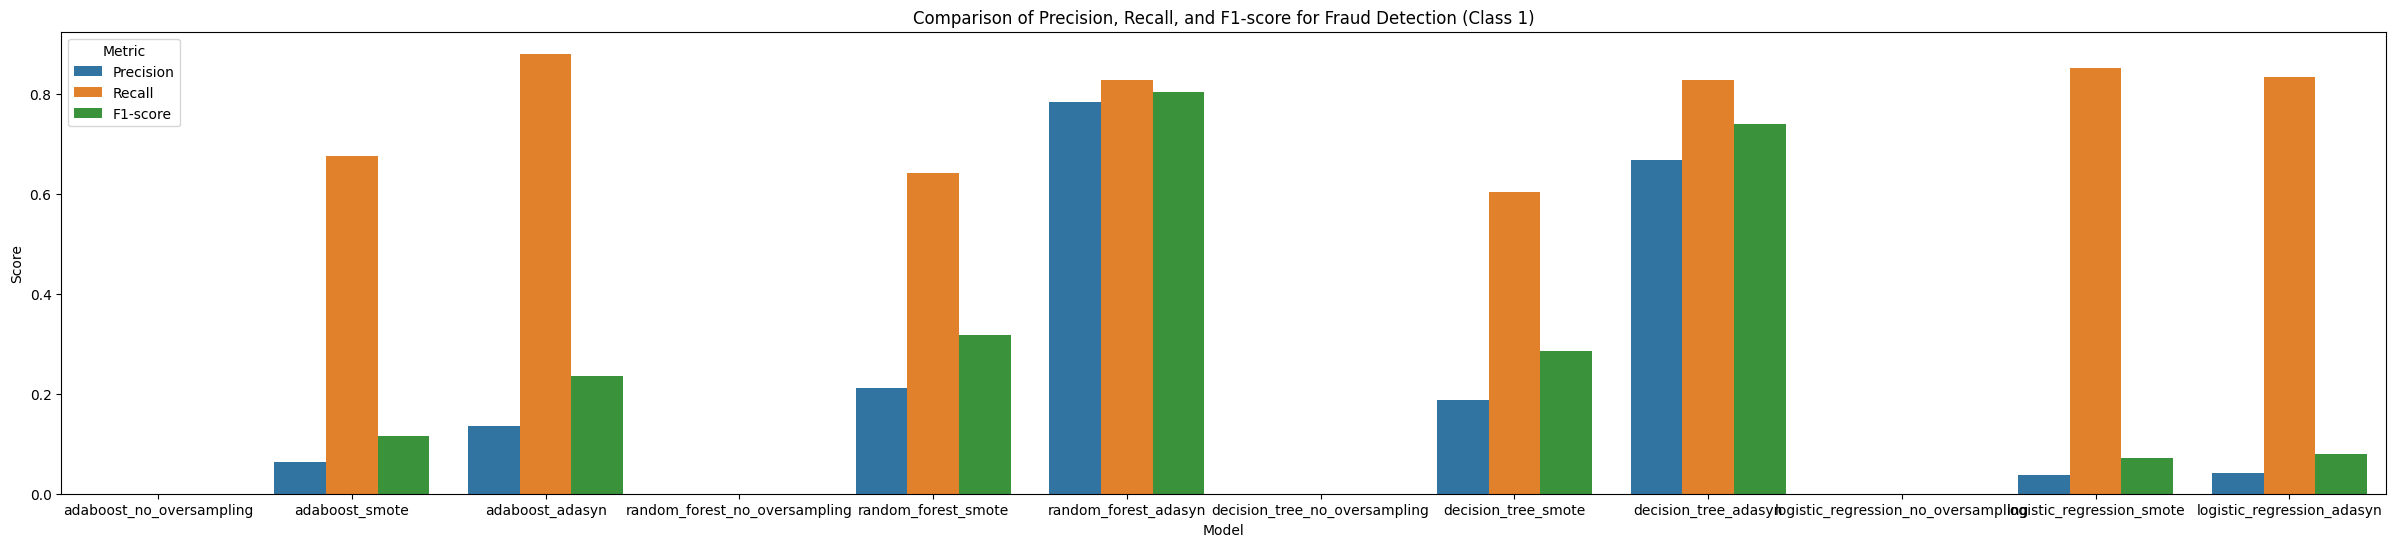

In [70]:
# Mengambil data untuk precision, recall, dan f1-score dari kelas fraud (1)
precision_1 = {model: metrics['1']['precision'] for model, metrics in data_cl_report.items()}
recall_1 = {model: metrics['1']['recall'] for model, metrics in data_cl_report.items()}
f1_score_1 = {model: metrics['1']['f1-score'] for model, metrics in data_cl_report.items()}

# Membuat DataFrame untuk visualisasi
df_plot_class_1 = pd.DataFrame({
    'Model': list(precision_1.keys()),
    'Precision': list(precision_1.values()),
    'Recall': list(recall_1.values()),
    'F1-score': list(f1_score_1.values())
})

# Plot menggunakan seaborn
df_plot_class_1_melt = df_plot_class_1.melt('Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(30, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_plot_class_1_melt)
plt.title('Comparison of Precision, Recall, and F1-score for Fraud Detection (Class 1)')
plt.savefig('comparison_report_class_1')
plt.show()

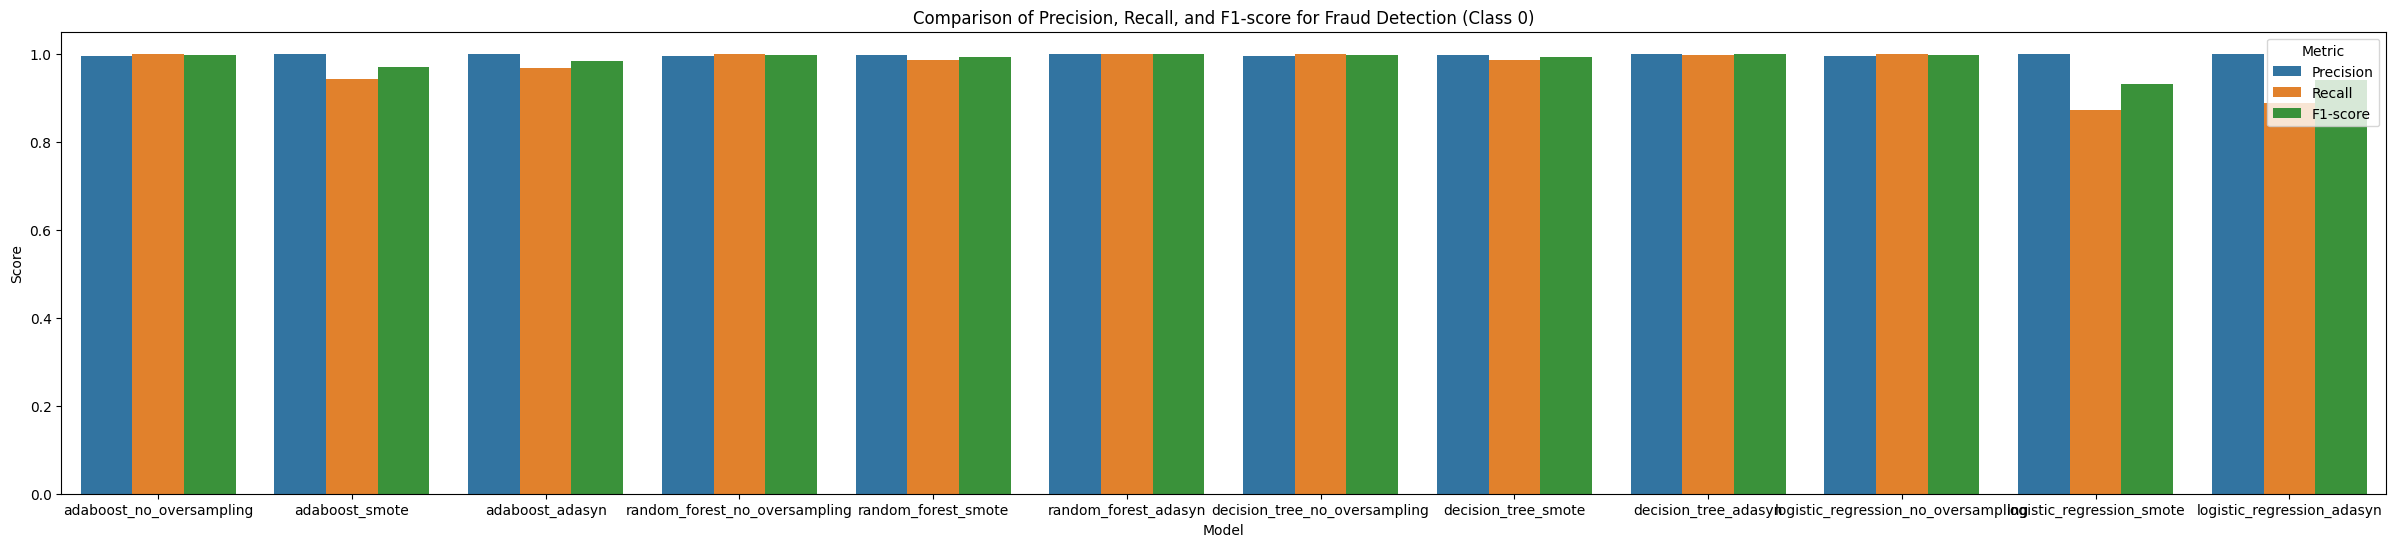

In [71]:
# Mengambil data untuk precision, recall, dan f1-score dari kelas non-fraud (0)
precision_0 = {model: metrics['0']['precision'] for model, metrics in data_cl_report.items()}
recall_0 = {model: metrics['0']['recall'] for model, metrics in data_cl_report.items()}
f1_score_0 = {model: metrics['0']['f1-score'] for model, metrics in data_cl_report.items()}

# Membuat DataFrame untuk visualisasi
df_plot_class_0 = pd.DataFrame({
    'Model': list(precision_0.keys()),
    'Precision': list(precision_0.values()),
    'Recall': list(recall_0.values()),
    'F1-score': list(f1_score_0.values())
})

# Plot menggunakan seaborn
df_plot_class_0_melt = df_plot_class_0.melt('Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(30, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_plot_class_0_melt)
plt.title('Comparison of Precision, Recall, and F1-score for Fraud Detection (Class 0)')
plt.savefig('comparison_report_class_0')
plt.show()